In [32]:
using CSV, DataFrames, Statistics
using PyPlot # plotting library
using PyCall
using Printf
using FStrings
using LaTeXStrings # for L"$x$" to work instead of needing to do "\$x\$"

# check out all of the styles! https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("seaborn-pastel")

# change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

#make jupyter notebook print more dataframe columns
ENV["COLUMNS"]=160

# important attributes for this analysis
hand = "basic"
subjects = ["sub1", "sub2", "sub3"]
t_labels = ["c","g"]
rotations = ["n"]
translations = ['a','b','c','d','e','f','g','h']

metrics = [:dist, :arc_len, :area_btwn, :max_a_loc, :max_a_reg, :max_err, :mvt_eff, :t_fd, :r_fd]
metric_sds = [:dist_sd, :arc_len, :area_btwn_sd, :max_a_loc_sd, :max_a_reg_sd, :max_err_sd, :mvt_eff_sd, :t_fd_sd, :r_fd_sd]

metric_to_color = Dict(:dist=>"xkcd:tan", :arc_len=>"xkcd:light blue", :area_btwn=>"xkcd:dark red", :max_a_loc=>"xkcd:light green", :max_a_reg=>"xkcd:dark green", :max_err=>"xkcd:blue grey", :mvt_eff=>"xkcd:dark orange", :r_fd=>"xkcd:red brown", :t_fd=>"xkcd:brown")


print("Ready to go!")

Ready to go!

-----

# Reading in the Data
Now reading in the metrics data for 2v2.

In [33]:
df_hand = CSV.read(f"results/{hand}_metrics.csv", DataFrame, copycols=true)
df_hand_avg = CSV.read(f"results/{hand}_avg_metrics.csv", DataFrame, copycols=true)
df_hand_std = CSV.read(f"results/{hand}_metric_sds.csv", DataFrame, copycols=true)
first(df_hand, 23)

,trial,arc_len,area_btwn,dist,max_a_loc,max_a_reg,max_err,mvt_eff,r_fd,t_fd
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,sub1_basic_c_n_1,0.424375,0.00119729,0.383838,0.299394,0.000260644,0.00848306,0.904479,0.7748,0.0459484
2,sub1_basic_c_n_3,0.392555,0.00120687,0.363636,0.603636,0.000275827,0.0114634,0.926332,0.7748,0.0366209
3,sub1_basic_c_n_4,0.453363,0.00282382,0.368687,0.604646,0.000993555,0.0220574,0.813226,1.4783,0.0330213
4,sub1_basic_c_n_5,0.415806,0.000421965,0.373737,0.269091,0.000191959,0.00432894,0.898825,1.0147,0.0778451
5,sub2_basic_c_n_1,1.2432,0.0101198,0.328283,0.590909,0.00198588,0.0160875,0.264062,2.2687,0.0313758
6,sub2_basic_c_n_2,0.580987,0.00183896,0.313131,0.563636,0.000407717,0.0110157,0.538965,0.5143,0.0254758
7,sub2_basic_c_n_4,0.742539,0.00371524,0.313131,0.569899,0.0008257,0.0171035,0.421704,2.4895,0.0402
8,sub2_basic_c_n_5,1.484,0.00687171,0.358586,0.566566,0.0021627,0.00977087,0.241634,0.7748,0.0314702
9,sub3_basic_c_n_2,0.851385,0.0081138,0.383838,0.115152,0.00319146,0.0331225,0.45084,1.7355,0.0313699


In [34]:
# breaking out important info from the trial id for easier data access

function condition_df(df::DataFrame)
    subject_nums = []
    translation_labels = []
    numbers = []
    for row in eachrow(df)
        label = row[:trial]
        #sub1_2v2_a_n_1
    #     push!(subject_nums, x[4])
    #     push!(translation_labels,x[10])
    #     push!(numbers, x[14])
        x = split(label, "_")
        push!(subject_nums, x[1][4])
        push!(translation_labels, x[3][1])
        push!(numbers, x[5][1])
    end
    s = convert(Array{Char,1}, subject_nums)
    d = convert(Array{Char,1}, translation_labels)
    n = convert(Array{Char,1}, numbers)

    insertcols!(df, 2, :subj=>s)
    insertcols!(df, 3, :dir=>d)
    insertcols!(df, 4, :num=>n)
end

condition_df(df_hand)
condition_df(df_hand_avg)
condition_df(df_hand_std)

first(df_hand, 2)

,trial,subj,dir,num,arc_len,area_btwn,dist,max_a_loc,max_a_reg,max_err,mvt_eff,r_fd,t_fd
,String,Char,Char,Char,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,sub1_basic_c_n_1,1,c,1,0.424375,0.00119729,0.383838,0.299394,0.000260644,0.00848306,0.904479,0.7748,0.0459484
2,sub1_basic_c_n_3,1,c,3,0.392555,0.00120687,0.363636,0.603636,0.000275827,0.0114634,0.926332,0.7748,0.0366209


## Asterisk Plot

![Avg Asterisk](./pics/avgd_2v2_3subs_n.jpg)

-----

# Histograms of Metrics
Now I will produce histogram plots of the metrics to see what kind of a distribution we get for all the trials.
Shamelessly taken from my previous datascience course at: [link](https://github.com/SimonEnsemble/data_science_course)

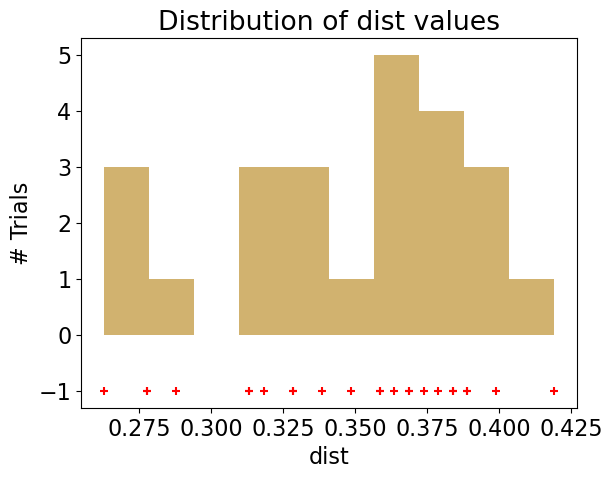

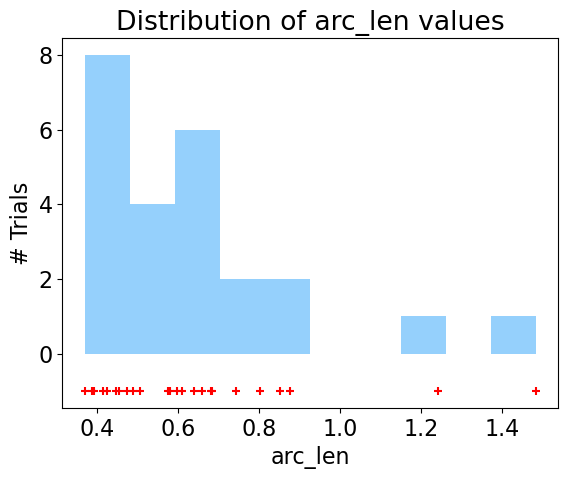

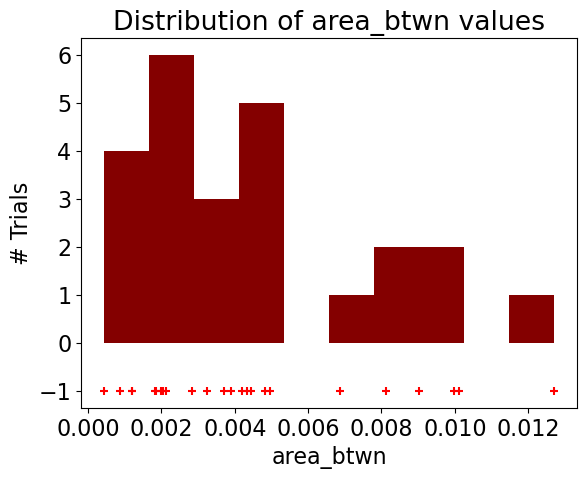

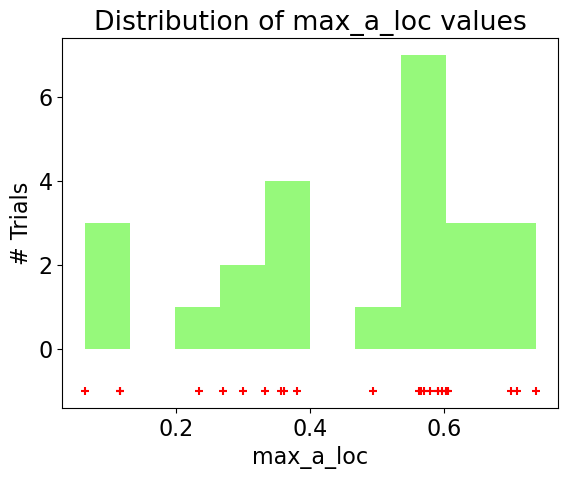

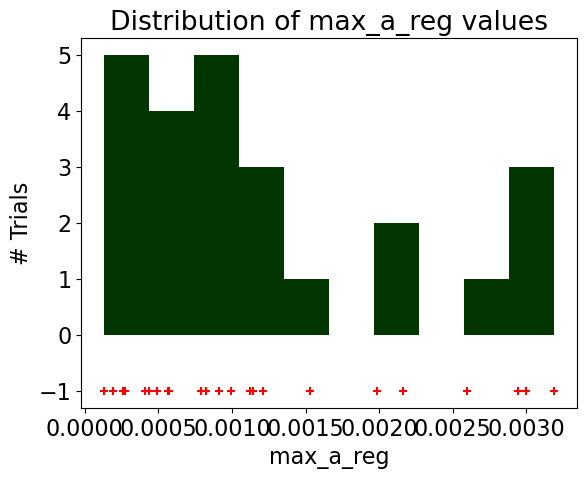

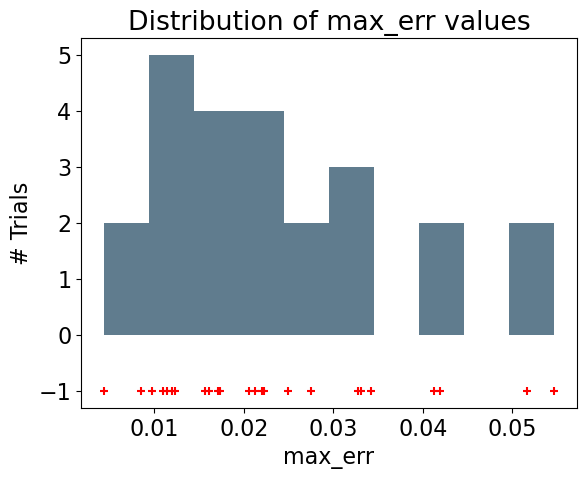

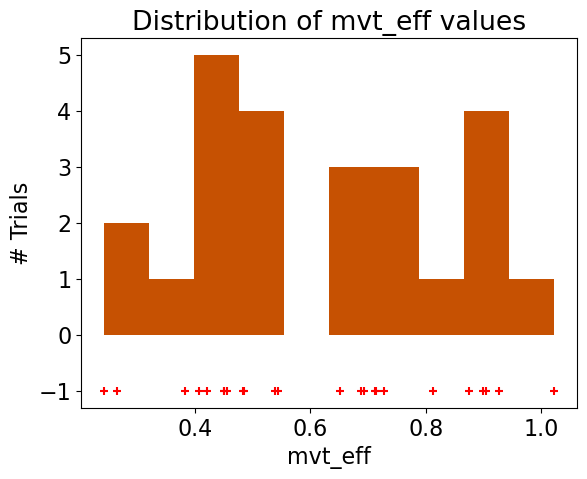

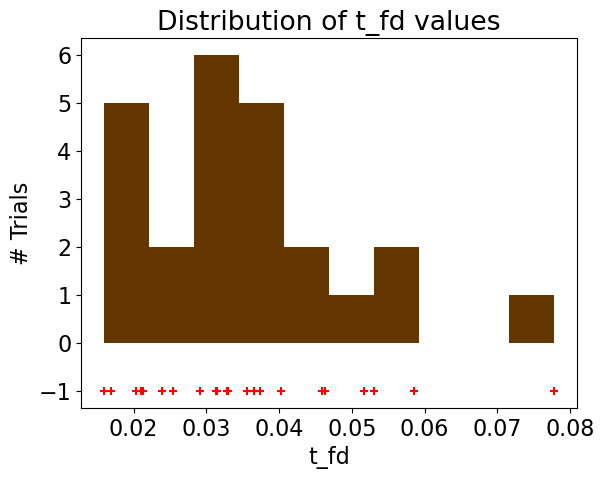

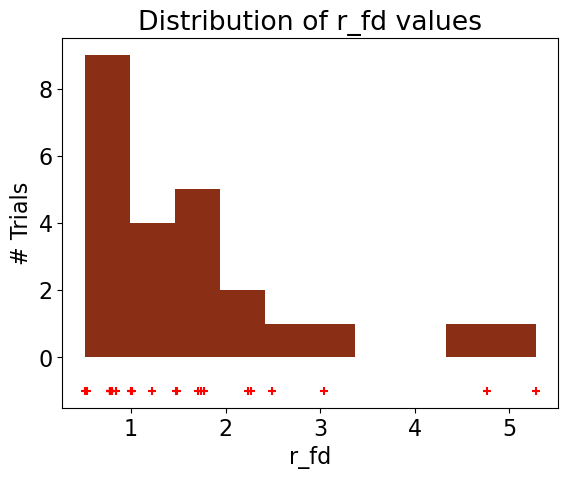

In [35]:

for m in metrics
    figure()
    hist(df_hand[:, m], color=metric_to_color[m]) #, normed=true)
    scatter(df_hand[:, m], [-1 for i = 1:nrow(df_hand)], marker="+", color="r")
    xlabel(f"{m}")
    ylabel("# Trials")
    title(f"Distribution of {m} values")
end

### Observations of Histogram Plots
Based on what I see, here are the observations per metric (in order of appearance top to down):
* **total distance**: values are distributed
* **arc length**: mostly concentrated at low arc lengths
* **max area region location**: mostly, the region of max error area is most commonly found at the end
* **max area region**: at the locations of max error area, the area of error (aka the area between the path and the target line) is still relatively low
* **max error**: values are distributed
* **movement efficiency**: values are distributed
* **rotational frechet distance**: aka max rotation error. Mostly low, but larger distribution at the low end
* translational frechet distance: all values are very low

----

# Metric Values by direction
Plot all metric values in bar charts by direction

In [36]:
# groups = groupby(df_hand, :dir)
# a_df = groups[1]
# b_df = groups[2]
# c_df = groups[3]
# d_df = groups[4]
# e_df = groups[5]
# f_df = groups[6]
# g_df = groups[7]
# h_df = groups[8]
# directions = [a_df, b_df, c_df, d_df, e_df, f_df, g_df, h_df]
# a_df

In [37]:
function compare_metrics(metric::Symbol, df::DataFrame) 
    dir_data = groupby(df, :dir)
    metric_data = []
    
    for dir in dir_data
        data = dir[!, metric]
        push!(metric_data, data)
    end
    plt_title = f"{hand}: {metric}"
    boxplot(metric_data)
    title(plt_title)
    xticks(1:2, t_labels)
    xlabel("Trial Directions")
end

println("Functions are ready!")

Functions are ready!


In [38]:
subjects = ["sub1", "sub2", "sub3"]
translations = ['a','b','c','d','e','f','g','h']
rotations = ["n"]

function get_trial_vals(df::DataFrame, metric::Symbol, translation::Char)
    desired_direction = filter(row -> row[:dir] == translation, df)
    names = desired_direction[!, :trial]
    values = desired_direction[!, metric]
    v = convert(Array{Float64,1}, values)  # just in case
    
    return v, names
end

function get_sd_vals(df::DataFrame, metric::Symbol, translation::Char)
    desired_direction = filter(row -> row[:dir] == translation, df)
    names = desired_direction[!, :trial]
    values = desired_direction[!, metric]
    v = convert(Array{Float64,1}, values)  # just in case
    
    return v, names
end

print("Functions are ready!")

Functions are ready!

-----

# Average Line Calculations

#### Dir: C
![Average Debug Plot for direction C](./pics/avgdebug_basic_3subs_c_n.jpg)

#### Dir: G
![Average Debug Plot for direction G](./pics/avgdebug_basic_3subs_g_n.jpg)



----

# Listing the Metric Values with standard deviations

In [39]:
first(df_hand_avg, 10)

,trial,subj,dir,num,arc_len,area_btwn,dist,max_a_loc,max_a_reg,max_err,mvt_eff,r_fd,t_fd
,String,Char,Char,Char,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,"{'sub1', 'sub2', 'sub3'}_basic_c_n_1",u,c,1,0.739793,0.00531831,0.366162,0.488687,0.00142516,0.0201922,0.590588,1.42082,0.0412313
2,"{'sub1', 'sub2', 'sub3'}_basic_g_n_1",u,g,1,0.54251,0.00358036,0.327862,0.431549,0.000952675,0.026759,0.638599,1.83604,0.0299244


In [40]:
first(df_hand_std, 10)

,trial,subj,dir,num,arc_len,area_btwn,dist,max_a_loc,max_a_reg,max_err,mvt_eff,r_fd,t_fd
,String,Char,Char,Char,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,"{'sub1', 'sub2', 'sub3'}_basic_c_n_1",u,c,1,0.328086,0.00396545,0.0319089,0.194784,0.00106648,0.0118319,0.236988,0.647249,0.0139629
2,"{'sub1', 'sub2', 'sub3'}_basic_g_n_1",u,g,1,0.107456,0.00205917,0.0412608,0.19144,0.00069995,0.013962,0.185411,1.56464,0.0120864


In [41]:
function print_avg_and_std(metric::Symbol)
    translations = ['a','b','c','d','e','f','g','h']
    

    for i in range(1,9, step=1)
        println(" ")
        println(f"{metrics[i]} metric")
        
        for t in translations
            vals, _ = get_trial_vals(df_hand_avg, metrics[i], t)
            stds, _ = get_trial_vals(df_hand_std, metrics[i], t)


            for i in range(1,length(vals), step=1)
                if ismissing(vals[i])
                    println(f"Dir {t}: missing")
                    continue
                end
                
                v = round(vals[i], digits=2)
                s = round(stds[i], digits=2)
                println(f"Dir {t}: {v} +/- {s}")

            end

#            print(t)
#            print(": ")
#            print(vals)
#            print(" | ")
#            println(stds)
        end
    end
end

print_avg_and_std(:t_fd)

 
dist metric
Dir c: 0.37 +/- 0.03
Dir g: 0.33 +/- 0.04
 
arc_len metric
Dir c: 0.74 +/- 0.33
Dir g: 0.54 +/- 0.11
 
area_btwn metric
Dir c: 0.01 +/- 0.0
Dir g: 0.0 +/- 0.0
 
max_a_loc metric
Dir c: 0.49 +/- 0.19
Dir g: 0.43 +/- 0.19
 
max_a_reg metric
Dir c: 0.0 +/- 0.0
Dir g: 0.0 +/- 0.0
 
max_err metric
Dir c: 0.02 +/- 0.01
Dir g: 0.03 +/- 0.01
 
mvt_eff metric
Dir c: 0.59 +/- 0.24
Dir g: 0.64 +/- 0.19
 
t_fd metric
Dir c: 0.04 +/- 0.01
Dir g: 0.03 +/- 0.01
 
r_fd metric
Dir c: 1.42 +/- 0.65
Dir g: 1.84 +/- 1.56


# T Tests for Symmetry

In [42]:
using HypothesisTests

In [43]:
function compare_2_directions(metric::Symbol)
    translations = ['c','g']
    results_report = zeros(2, 2)
    
    for t in translations
        i = findall(x->x==t, translations)[1]
        n = 0
        
        for t2 in translations[i:end]
            v1, _ = get_trial_vals(df_hand, metric, t)
            v2, _ = get_trial_vals(df_hand, metric, t2)
            
            result = pvalue(UnequalVarianceTTest(v1, v2))
            r = round(result, digits=4)
            results_report[i, i+n] = r
            
            n = n+1
        end
        println(" ")
    end

    r_df = DataFrame(trials=translations = ["c", "g"], 
                     c=results_report[1,:],g=results_report[2,:])
    
    return r_df
end

# temp = compare_2_directions(:arc_len)
println("Functions are ready!")

Functions are ready!


In [44]:
# for m in metrics
#     maxes = []
#     mins = []
#     r = compare_2_directions(m)
    
#     println(f"{m} data")
#     println("   ")
#     println(r)
#     println("================================================")
#     println("    ")
# end

----

# Data Analysis 

![Avg Asterisk](./pics/avgd_basic_3subs_n.jpg)

**Hypotheses:**
* df

### Total Distance Travelled


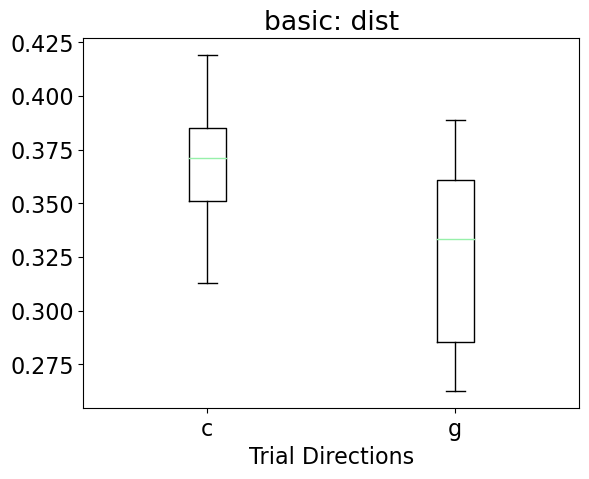

,trials,c,g
,String,Float64,Float64
1,c,1.0,0.0
2,g,0.024,1.0


In [45]:
compare_metrics(:dist, df_hand)
compare_2_directions(:dist)

### Arc Length

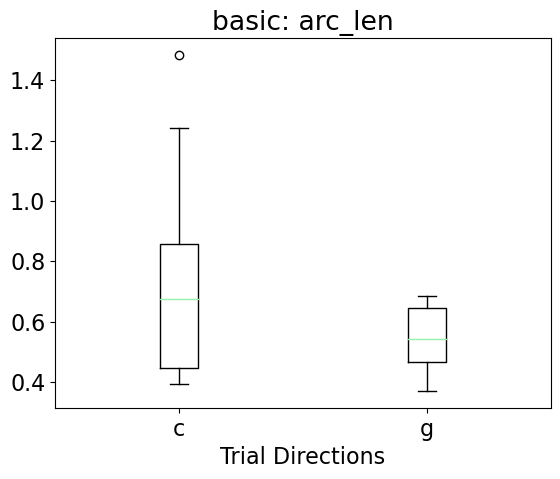

,trials,c,g
,String,Float64,Float64
1,c,1.0,0.0
2,g,0.0799,1.0


In [46]:
compare_metrics(:arc_len, df_hand)
compare_2_directions(:arc_len)

### Movement Efficiency
total_distance / arc_length

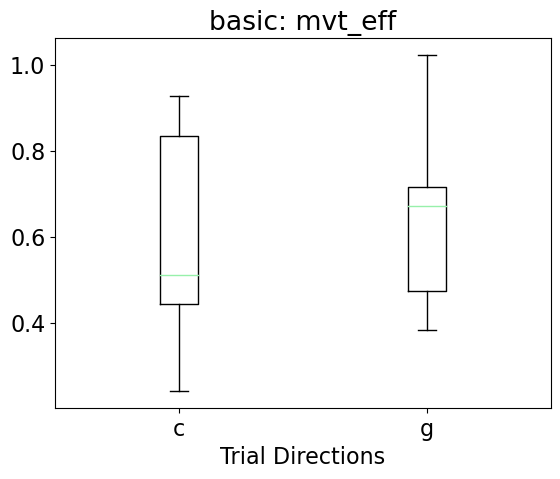

,trials,c,g
,String,Float64,Float64
1,c,1.0,0.0
2,g,0.6023,1.0


In [47]:
compare_metrics(:mvt_eff, df_hand)
compare_2_directions(:mvt_eff)

### Max Error

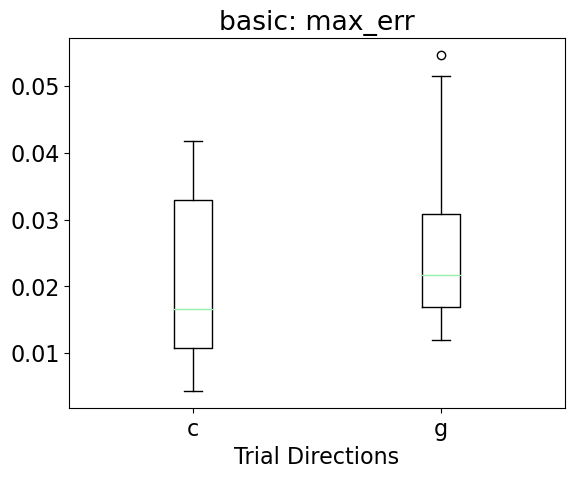

,trials,c,g
,String,Float64,Float64
1,c,1.0,0.0
2,g,0.247,1.0


In [48]:
compare_metrics(:max_err, df_hand)
compare_2_directions(:max_err)

### Translational Frechet Distance

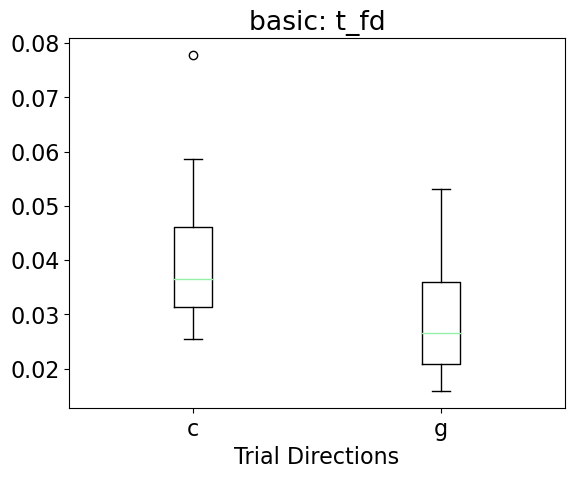

,trials,c,g
,String,Float64,Float64
1,c,1.0,0.0
2,g,0.0548,1.0


In [49]:
compare_metrics(:t_fd, df_hand)
compare_2_directions(:t_fd)

### Max Rotation Error / Rotational Frechet Distance

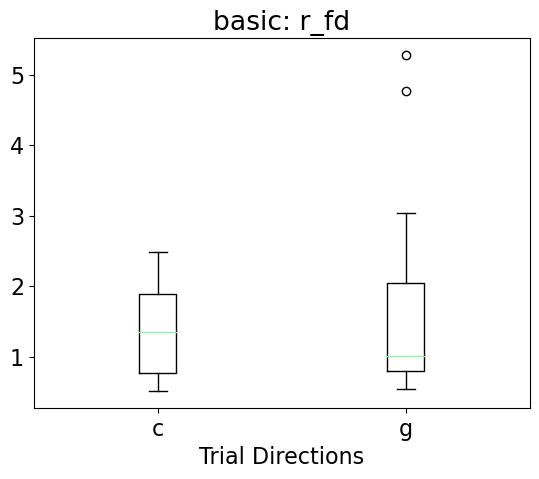

,trials,c,g
,String,Float64,Float64
1,c,1.0,0.0
2,g,0.429,1.0


In [50]:
compare_metrics(:r_fd, df_hand)
compare_2_directions(:r_fd)

### Total Area Between Curves
Between object path and target line

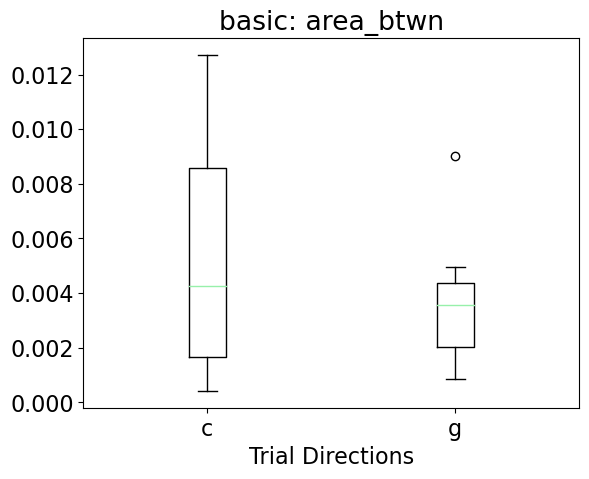

,trials,c,g
,String,Float64,Float64
1,c,1.0,0.0
2,g,0.2148,1.0


In [51]:
compare_metrics(:area_btwn, df_hand)
compare_2_directions(:area_btwn)

### Max Area Region
The area between the curves of a scrolling window of about 20% total_distance width.

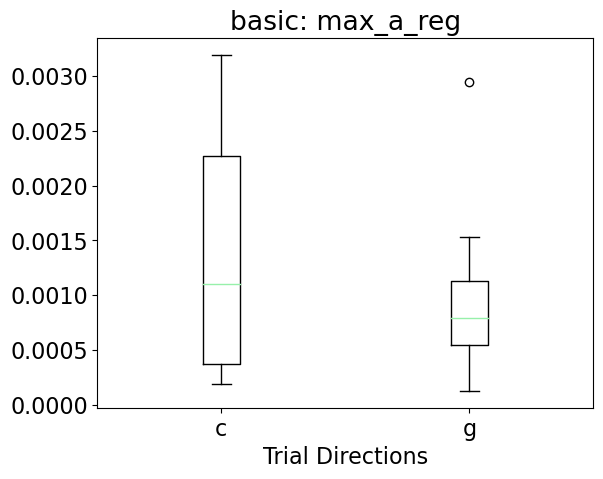

,trials,c,g
,String,Float64,Float64
1,c,1.0,0.0
2,g,0.2343,1.0


In [52]:
compare_metrics(:max_a_reg, df_hand)
compare_2_directions(:max_a_reg)

### Max Area Location
The location of the center of the max area region, represented as a percentage along the full target line (that is, some percentage of 0.5).

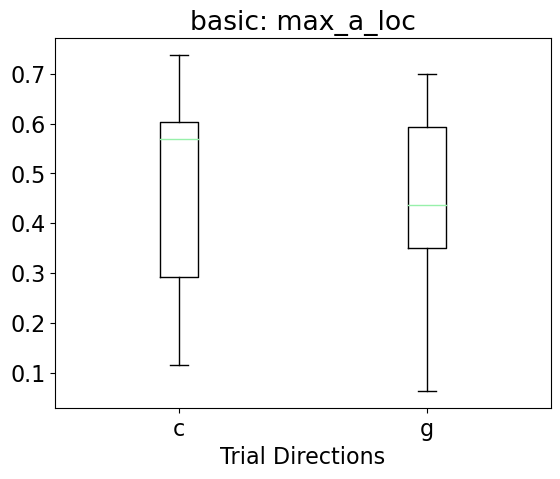

,trials,c,g
,String,Float64,Float64
1,c,1.0,0.0
2,g,0.495,1.0


In [53]:
compare_metrics(:max_a_loc, df_hand)
compare_2_directions(:max_a_loc)

-----

## Comparing PValues Directly, Direction to Direction, all Metrics

In [54]:
translations = ['a','b','c','d','e','f','g','h']
results_report = zeros(8, 8)

for t in translations
    i = findall(x->x==t, translations)[1]
    n = 0

    for t2 in translations[(i+1):end]
        println(f"{t} v {t2}")
        for m in metrics
            v1, _ = get_trial_vals(df_hand, m, t)
            v2, _ = get_trial_vals(df_hand, m, t2)

            result = pvalue(UnequalVarianceTTest(v1, v2))
            r = round(result, digits=4)
            println(f"{m} => {r}")
        end

        println("  ")
    end
    println("====================")
end

a v b


LoadError: [91mArgumentError: TDist: the condition ν > zero(ν) is not satisfied.[39m

In [55]:
function aggregate_pvalues()
    translations = ['a','b','c','d','e','f','g','h']
    results_report = zeros(8, 8)
    
    for t in translations
        i = findall(x->x==t, translations)[1]
        n = 0
        
        for t2 in translations[i:end]
            total_sigs = 0
            
            for m in metrics
                v1, _ = get_trial_vals(df_hand, m, t)
                v2, _ = get_trial_vals(df_hand, m, t2)

                result = pvalue(UnequalVarianceTTest(v1, v2))
                
                if result <= 0.05
                    total_sigs = total_sigs + 1
                end
                
                if t == t2
                    total_sigs = NaN
                end
            end
            perc_sigs = total_sigs / length(metrics)
            results_report[i, i+n] = perc_sigs
            
            n = n+1
        end
        println(" ")
    end

    r_df = DataFrame(trials=translations = ["a", "b", "c", "d", "e", "f", "g", "h"], 
                     a=results_report[1,:], b=results_report[2,:], c=results_report[3,:],
                     d=results_report[4,:], e=results_report[5,:], f=results_report[6,:],
                     g=results_report[7,:], h=results_report[8,:])
    
    return r_df
end

aggregate_results = aggregate_pvalues()
# CSV.write(aggregate_results)
aggregate_results

LoadError: [91mArgumentError: TDist: the condition ν > zero(ν) is not satisfied.[39m

In [56]:
colormap = PyPlot.matplotlib.cm.get_cmap("bwr")
colors = colormap.(reverse(range(0.1, stop=0.9, length=10)))

10-element Array{NTuple{4,Float64},1}:
 (1.0, 0.196078431372549, 0.196078431372549, 1.0)
 (1.0, 0.3764705882352941, 0.3764705882352941, 1.0)
 (1.0, 0.5568627450980392, 0.5568627450980392, 1.0)
 (1.0, 0.7294117647058824, 0.7294117647058824, 1.0)
 (1.0, 0.9098039215686274, 0.9098039215686274, 1.0)
 (0.9098039215686274, 0.9098039215686274, 1.0, 1.0)
 (0.7294117647058823, 0.7294117647058823, 1.0, 1.0)
 (0.5568627450980392, 0.5568627450980392, 1.0, 1.0)
 (0.3764705882352941, 0.3764705882352941, 1.0, 1.0)
 (0.19607843137254902, 0.19607843137254902, 1.0, 1.0)

In [57]:
# make a nice table with color coding, highlighting directions that have and don't have significant differences from each other

fig, ax = subplots()

# Hide axes because there isn't a plot to go with it
ax.axis("off")

results_table = convert(Matrix, aggregate_results)
# the_table = table(results_table, colLabels=names(aggregate_results))

# the_table.get_celld()[(1,0)].set_facecolor("#56b5fd")

# colormap = PyPlot.matplotlib.cm.get_cmap("bwr")

# for i in range(1, stop=8)
#     for j in range(1, stop=9)
#         val = aggregate_results[i,j]
        
#         if typeof(val) == String
#             c = "xkcd:grey blue"
#         elseif isnan(val)
#             c = "xkcd:dark grey"
#         else
#             c = colormap(val)
#         end
        
#         the_table.get_celld()[(i-1,j-1)].set_facecolor(c)
#     end
# end


LoadError: [91mUndefVarError: aggregate_results not defined[39m

![Avg Asterisk](./pics/avgd_2v2_3subs_n.jpg)

# Clustering for Symmetry

In [58]:
using Clustering

# use kmeans or hierarchical clustering single linkage?

In [59]:
test = [1, 2, 3, 4, 5]
t = 2
i = findall(x->x!=t, test)

4-element Array{Int64,1}:
 1
 3
 4
 5